### Data Analysis of SQL Injection data

In [ ]:
#Importing required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
import os
import requests


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import LSTM
import numpy as np
from sklearn.metrics import classification_report

import tensorflow_addons as tfa





In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
import pickle

In [ ]:
#Importing the data
sqli_data = pd.read_csv("Modified_SQL_Dataset.csv")

In [ ]:
#Checking the head and tail of the data
sqli_data.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


In [ ]:
sqli_data.tail()

,Query,Label
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0
30918,SELECT TOP 3 * FROM race,0


In [ ]:
#Information about data
sqli_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


In [ ]:
#Checking the count of labels present in data
sqli_data['Label'].value_counts()

0    19537
1    11382
Name: Label, dtype: int64

In [ ]:
#checking the count and other stuffs.
sqli_data.describe()

,Label
count,30919.000000
mean,0.368123
std,0.482303
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
sqli_data.shape

(30919, 2)

In [ ]:
sqli_data.isnull().sum()

Query    0
Label    0
dtype: int64

Per above output no rows are having null values

We can now check for distribution of labels in our data.

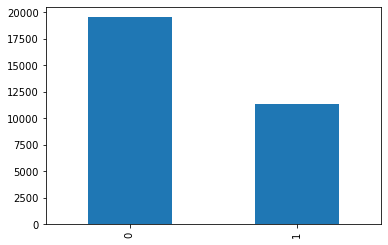

In [ ]:
#checking the disb of labels using bar plot
sqli_data['Label'].value_counts().plot(kind = 'bar')

From the above plot, it is evident that class label '0' is ALMOST twice as that of label '1'.

find duplicate rows in both columns

In [ ]:
#find duplicate rows across all columns
sqli_data[sqli_data.duplicated(keep=False)]

,Query,Label
656,#NAME?,1
866,#NAME?,1
12737,1.94E+15,0
12959,1.86E+15,0
13318,#NAME?,0
13532,#NAME?,0
14626,1.94E+15,0
15635,#NAME?,0
17255,1.86E+15,0
17913,#NAME?,0


There are 21 duplicate values present in the data and none of the entries look like SQL queries.

In [ ]:
# dropping duplicate values
sqli_data.drop_duplicates(keep=False,inplace=True)

In [ ]:
sqli_data.iloc[5370]

Query    1"   )    )    as bosq where 4695  =  4695
Label                                             1
Name: 5372, dtype: object

Since most of the sql queries are having special characters so removing them from text data as it would not add any value to the analysis. 

In [ ]:
example_data = sqli_data['Query'][5111]

In [ ]:
#importing regex library for data cleaning
import re

In [ ]:
# Removing spaces first using regex
def eliminate_space(example_data):
    cleaned_data = re.sub('\s{2,}',' ',example_data).lower().strip()
    return cleaned_data

In [ ]:
print(eliminate_space(example_data))

1'+ ( select 'mgrj' where 8514 = 8514 or row ( 1045,7562 ) > ( select count ( * ) ,concat ( 0x7171706a71, ( select ( elt ( 1045 = 1045,1 ) ) ) ,0x717a767a71,floor ( rand ( 0 ) *2 ) ) x from ( select 8488 union select 5584 union select 3051 union select 1210 ) a group by x ) ) +'


In [ ]:
# Cleaning all special characters and spaces also
def remove_all(example_data):
    cleaned = re.sub('[^a-zA-Z0-9\s]',' ',example_data)
    cleaned = re.sub('\s{2,}',' ',cleaned)
    return cleaned.lower().strip()

In [ ]:
print(remove_all(example_data))

1 select mgrj where 8514 8514 or row 1045 7562 select count concat 0x7171706a71 select elt 1045 1045 1 0x717a767a71 floor rand 0 2 x from select 8488 union select 5584 union select 3051 union select 1210 a group by x


In [ ]:
#applying the cleaning function to all values in the datase
sqli_data['Query'] = sqli_data['Query'].apply(remove_all)

In [ ]:
sqli_data[sqli_data.duplicated(keep=False)]

,Query,Label
0,or pg sleep time,1
3,select from users where id 1 or 1 1 union sele...,1
4,select from users where id 1 or 1 union select...,1
6,select from users where id 1 or 1 1 1,1
8,select from users where id 1 or 1 1 union sele...,1
...,...,...
20330,select customername concat address postalcode ...,0
20336,select customers customername orders orderid f...,0
20354,select column name s from table name,0
20355,select count customerid countryfrom customersg...,0


In [ ]:
sqli_data.drop_duplicates(keep='first',inplace=True)

Lets check for any empty queries & very long queries as well

In [ ]:
qlength = sqli_data.Query.map(lambda x:len(x.split()))


In [ ]:
#checking for empty query
sqli_data[qlength==0]

,Query,Label
208,,1


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

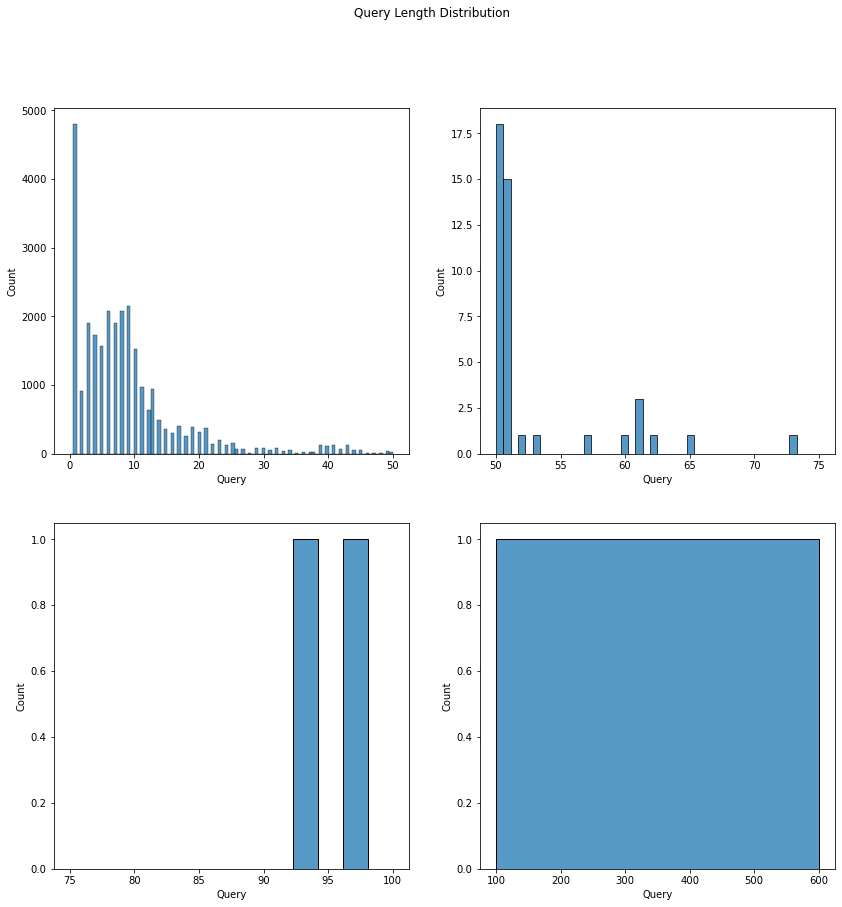

In [ ]:
#Plotting the query length

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,14))
sns.histplot(qlength, binrange=(0,50), ax=ax1)
sns.histplot(qlength, binrange=(50,75), ax=ax2)
sns.histplot(qlength, binrange=(75,100), ax=ax3)
sns.histplot(qlength, binrange=(100,600), ax=ax4)
plt.suptitle("Query Length Distribution");

In [ ]:
# Plotting the number of query words
print("0 words   =", (qlength==0).value_counts()[True])
print("1 words   =", (qlength==1).value_counts()[True])
print("2 words   =", (qlength==2).value_counts()[True])
print("Less than 5 words   =", (qlength<5).value_counts()[True])
print("Less than 10 words  =", (qlength<10).value_counts()[True])
print("Less than 15 words  =", (qlength<15).value_counts()[True])
print("Less than 50 words  =", (qlength<50).value_counts()[True])
print("More than 90 words =", (qlength>90).value_counts()[True])
print("More than 500 words =", (qlength>500).value_counts()[True])

0 words   = 1
1 words   = 4797
2 words   = 918
Less than 5 words   = 9342
Less than 10 words  = 19110
Less than 15 words  = 23691
Less than 50 words  = 28094
More than 90 words = 3
More than 500 words = 1


####  Observations

From histogram, percentiles based on query length

90% of the queries are having 19 or less words.

95% of the queries are having 26 or less words.

Less than 1% of the data have more than 43 words.

Only one outlier query has 542 words.

Only one outlier query has 0 words.

In [ ]:
for per in range(10,101,10):
    print(f'{per} percentile for query length = {np.percentile(qlength, per)}')
print('-'*40)
for per in range(91,101,1):
    print(f'{per} percentile for query length = {np.percentile(qlength, per)}')
print('-'*40)
for per in np.linspace(99,100,11):
    print(f'{per} percentile for query length = {np.percentile(qlength, per)}')

10 percentile for query length = 1.0
20 percentile for query length = 2.0
30 percentile for query length = 4.0
40 percentile for query length = 6.0
50 percentile for query length = 7.0
60 percentile for query length = 8.0
70 percentile for query length = 10.0
80 percentile for query length = 13.0
90 percentile for query length = 19.0
100 percentile for query length = 542.0
----------------------------------------
91 percentile for query length = 20.0
92 percentile for query length = 21.0
93 percentile for query length = 22.0
94 percentile for query length = 24.0
95 percentile for query length = 26.0
96 percentile for query length = 30.0
97 percentile for query length = 36.0
98 percentile for query length = 40.0
99 percentile for query length = 43.0
100 percentile for query length = 542.0
----------------------------------------
99.0 percentile for query length = 43.0
99.1 percentile for query length = 43.0
99.2 percentile for query length = 44.0
99.3 percentile for query length = 44.0


In [ ]:
qlength.max()

542

In [ ]:
sqli_data[qlength==542]

,Query,Label
19341,de email address find account answer cdata fqa...,0


Removing the outliers that is the query with length zero and max length as it will not add any value to analysis

In [ ]:
#dropping the 2 rows
sqli_data.drop([208,19341],inplace=True)

In [ ]:
# saving the cleaned dataset using pickle
import pickle, os

In [ ]:
os.getcwd()

'C:\\Users\\ankit\\SQLI_detection'

In [ ]:
sqli_data.to_pickle("./sqli_data_df.pkl")

### Now we will visaulize data using t-SNE

Before visualzing we will have to vectorize the data and then visualize it, so we will use both CountVectorizer and Tf-IDf vectorizer

In [ ]:
X = sqli_data['Query']
y = sqli_data['Label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=2000)
X_tr_vec = vectorizer.fit_transform(X_train)
X_te_vec = vectorizer.transform(X_test)

In [ ]:
from sklearn.manifold import TSNE
tsne_data = TSNE(perplexity=100).fit_transform(X_tr_vec, y_train)

In [ ]:
import seaborn as sns

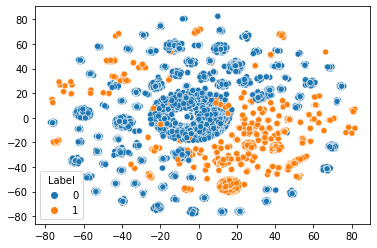

In [ ]:
tsne_data = TSNE(perplexity=50, n_iter=1000).fit_transform(X_tr_vec, y_train)
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=y_train, legend='full')

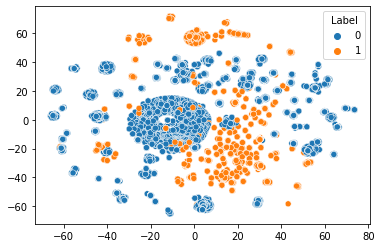

In [ ]:
#Increasing perplexity to 100
tsne_data = TSNE(perplexity=100, n_iter = 1000).fit_transform(X_tr_vec, y_train)
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=y_train, legend='full')

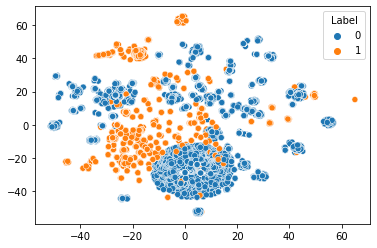

In [ ]:
#Increasing perplexity to 200
tsne_data = TSNE(perplexity=200, n_iter=1000).fit_transform(X_tr_vec, y_train)
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=y_train, legend='full')

### T-SNE visulisation With tf-idf vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2000)
X_tr_tfidfvec = tfidf_vectorizer.fit_transform(X_train)
X_te_tfidfvec = tfidf_vectorizer.transform(X_test)


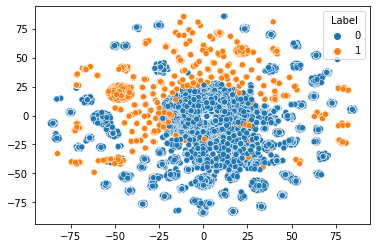

In [ ]:
tsne_data = TSNE(perplexity=50, n_iter=1000).fit_transform(X_tr_tfidfvec, y_train)
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=y_train, legend='full')

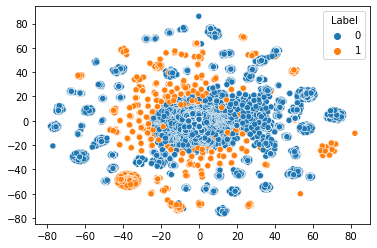

In [ ]:
tsne_data = TSNE(perplexity=100, n_iter=1000).fit_transform(X_tr_tfidfvec, y_train)
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=y_train, legend='full')

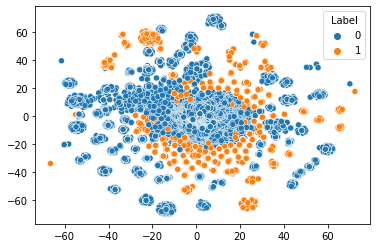

In [ ]:
tsne_data = TSNE(perplexity=200, n_iter=1000).fit_transform(X_tr_tfidfvec, y_train)
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=y_train, legend='full')

In [ ]:
X = sqli_data['Query']
y = sqli_data['Label']

In [ ]:
#Splitting the data in to test and train
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [ ]:
#Checking if split happened in 70/30 fashion or not
y_train.value_counts()

0    13624
1     6072
Name: Label, dtype: int64

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
count_vectorizer = CountVectorizer(ngram_range=(1,3), max_features=2500)
X_tr_vec = count_vectorizer.fit_transform(X_train)
X_te_vec = count_vectorizer.transform(X_test)

In [ ]:
## https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_tr_tfidf_vec = tfidf_vectorizer.fit_transform(X_train)
X_te_tfidf_vec = tfidf_vectorizer.transform(X_test)

In [ ]:
# saving the vectorizer for reuse later

with open('./tfidf_vec.sav', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [ ]:
#https://towardsdatascience.com/ultimate-function-for-classification-82f1fc711ab9
#https://realpython.com/python-eval-function/


def evaluate_model(model, train_data, train_label, model_name = 'Model', cv=3):
    print(f'Evaluating {model_name}...')
    global X_te_tfidf_vec
    global y_test
    train_accuracy_score = model.score(train_data, train_label)
    test_accuracy_score = model.score(X_te_tfidf_vec, y_test)
  
    print('Classifier Training Accuracy = ',round(train_accuracy_score*100, 2), ' %')
    print('Classifier Test Accuracy = ',round(test_accuracy_score*100, 2), ' %')
  
    y_predictions = model.predict(X_te_tfidf_vec)
    print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,2)} %")
    confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

    cross_val_f1 = cross_val_score(model, train_data, train_label, cv=cv, scoring='f1')
    print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

    fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
    print("roc_auc = ", round(roc_auc*100,2))

    figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(17,8))
    confusion_mat.plot(ax=ax1)
    ax1.set_title('CONFUSION MATRIX')
    roc_display.plot(ax=ax2)
    ax2.set_title('ROC-AUC')
    figure.suptitle(model_name)

### Now we will use KNN algorithm on the data and see how it performs

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knn_model = KNeighborsClassifier()
knn_model.fit(X_tr_tfidf_vec, y_train)

KNeighborsClassifier()

Evaluating KNN Classifier...
Classifier Training Accuracy =  99.4  %
Classifier Test Accuracy =  99.49  %
F1 Score for KNN Classifier: 99.17 %
cross_validation f1-scores for KNN Classifier 
 [0.98371336 0.98751872 0.98701299]
roc_auc =  99.22


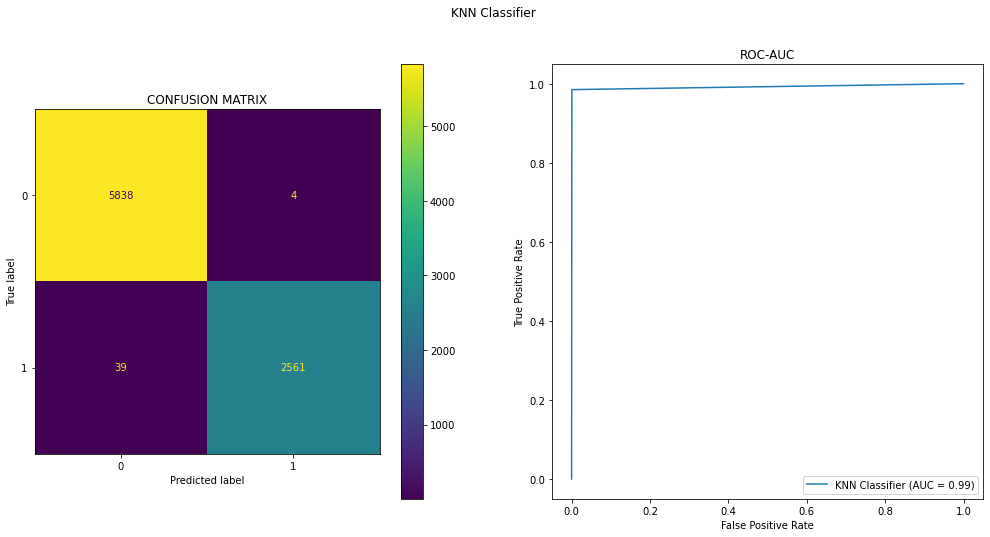

In [ ]:
#Now using eval function on k-NN  classifier
evaluate_model(knn_model, train_data = X_tr_tfidf_vec, train_label=y_train, model_name='KNN Classifier')

### Now using GridsearchCV for parameter search

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
knn_mdl_gscv = KNeighborsClassifier()
knn_params = {'n_neighbors':(1,3,5,7,9,11,13,19), 'metric':('euclidean','minkowski')}

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
knn_clsf_gscv = GridSearchCV(estimator = knn_mdl_gscv, param_grid = knn_params, n_jobs=-1, scoring='f1')

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
knn_clsf_gscv.fit(X_tr_tfidf_vec, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ('euclidean', 'minkowski'),
                         'n_neighbors': (1, 3, 5, 7, 9, 11, 13, 19)},
             scoring='f1')

In [ ]:
# Stroing the result in a dataframe will be using it for viz.
cv_rslt = pd.DataFrame(knn_clsf_gscv.cv_results_)

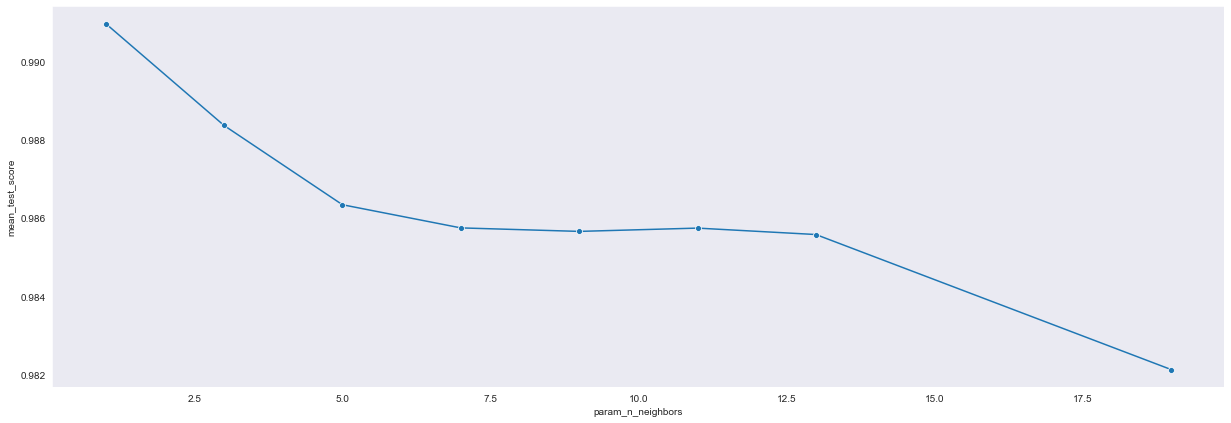

In [ ]:
# Using seaborn to plot the gridsearch results.
sns.set_style("dark")
fig = plt.figure(figsize=(21,7))
sns.lineplot(data = cv_rslt[cv_rslt['param_metric']=='minkowski'], x='param_n_neighbors', y='mean_test_score', marker="o")

### KNN model will now be tuned based on grid search results.

In [ ]:
knn_tuned = KNeighborsClassifier(n_neighbors=7)

Evaluating Tuned_KNN_Classifier...
Classifier Training Accuracy =  99.23  %
Classifier Test Accuracy =  99.48  %
F1 Score for Tuned_KNN_Classifier: 99.15 %
cross_validation f1-scores for Tuned_KNN_Classifier 
 [0.98320381 0.98725956 0.98650675]
roc_auc =  99.2


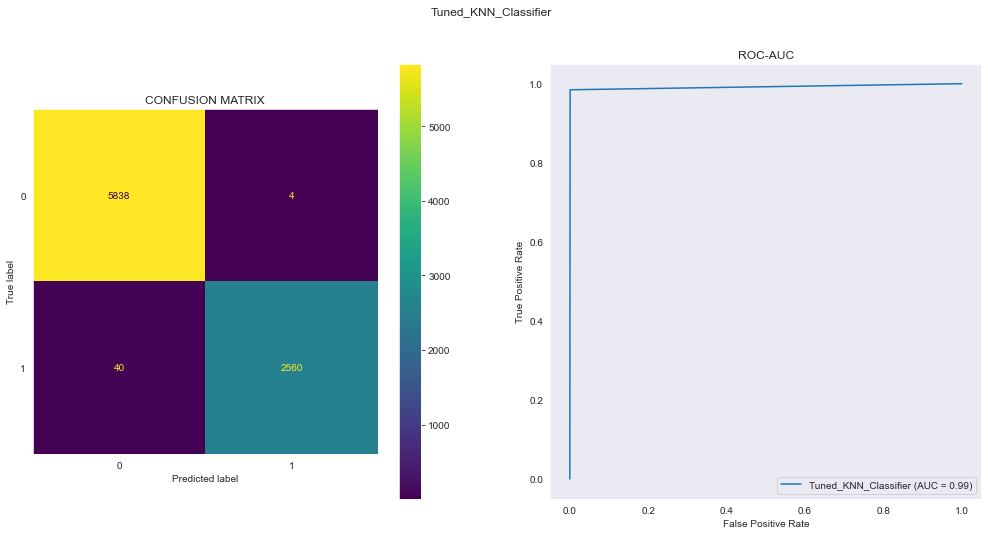

In [ ]:
# Fitting the tuned model based on gridsearch CV resluts and calling custom function again.
knn_tuned.fit(X_tr_tfidf_vec, y_train)
evaluate_model(knn_tuned, train_data=X_tr_tfidf_vec, train_label=y_train, model_name='Tuned_KNN_Classifier')

#### KNN model accuracy is good, will check for other models now and see how they are performing better or worse than k-NN

### Applying Logistic Regression Model on sql injection data

In [ ]:
# Logistic regression,https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression

log_reg_mdl = LogisticRegression()
log_reg_mdl.fit(X_tr_tfidf_vec, y_train)

LogisticRegression()

In [ ]:
log_reg_mdl_gscv = LogisticRegression()
log_reg_params = {'C':(0.1, 0.5, 1.0, 5.0, 10.0), 'penalty':('l1', 'l2', 'elasticnet'), 'solver':('lbfgs', 'saga'), 'max_iter':[1000]}


In [ ]:
log_reg_clf_gscv = GridSearchCV(estimator = log_reg_mdl_gscv , param_grid = log_reg_params , n_jobs=-1, scoring='f1')
log_reg_clf_gscv.fit(X_tr_tfidf_vec, y_train)

C:\Users\ankit\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0), 'max_iter': [1000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('lbfgs', 'saga')},
             scoring='f1')

In [ ]:
log_reg_cv_results = pd.DataFrame(log_reg_clf_gscv.cv_results_)

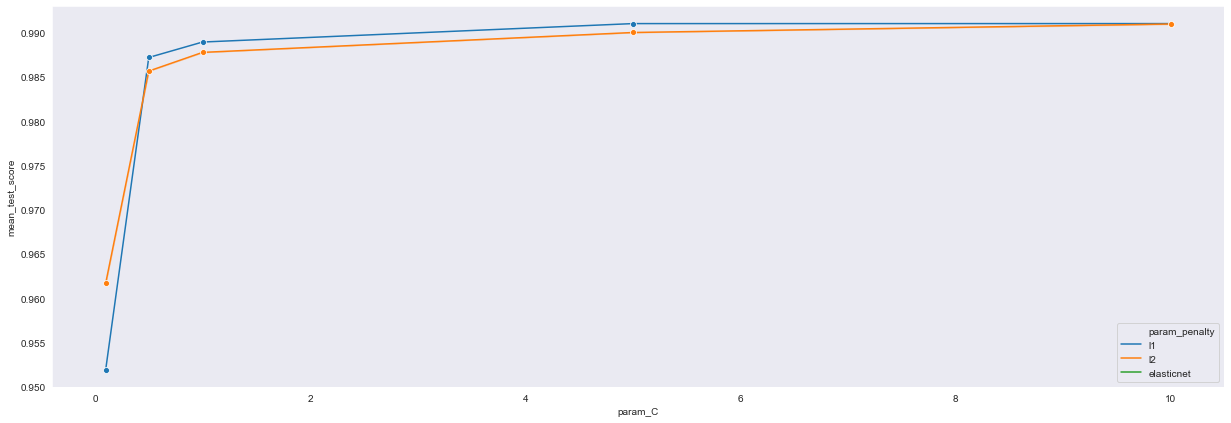

In [ ]:
figure = plt.figure(figsize=(21,7))
sns.lineplot(data = log_reg_cv_results , x='param_C', y='mean_test_score', hue='param_penalty' ,marker="o")

#### L1 regularization seems to be giving better accuracy than L2 and elastic net, so will be using the same

In [ ]:
tuned_log_reg_mdl = LogisticRegression(C=5.0, penalty='l1', solver= 'saga', max_iter=1000)
tuned_log_reg_mdl.fit(X_tr_tfidf_vec, y_train)

LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='saga')

Evaluating Tuned Logistic Regression Model...
Classifier Training Accuracy =  99.74  %
Classifier Test Accuracy =  99.59  %
F1 Score for Tuned Logistic Regression Model: 99.32 %


C:\Users\ankit\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


cross_validation f1-scores for Tuned Logistic Regression Model 
 [0.98953662 0.99032018 0.99180531]
roc_auc =  99.38


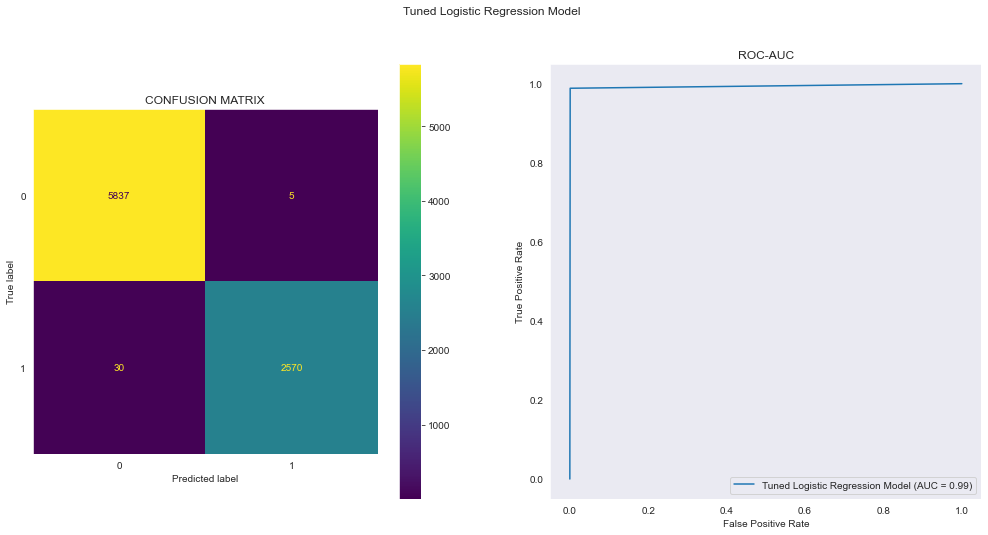

In [ ]:
evaluate_model(tuned_log_reg_mdl , train_data=X_tr_tfidf_vec, train_label=y_train, model_name='Tuned Logistic Regression Model')

#### Logistic regression model has better accuracy than k-NN model

#### Now we will apply Random Forest model on the data.

Evaluating Random Forest Model...
Classifier Training Accuracy =  99.77  %
Classifier Test Accuracy =  99.6  %
F1 Score for Random Forest Model: 99.34 %
cross_validation f1-scores for Random Forest Model 
 [0.99279145 0.99353877 0.99229431]
roc_auc =  99.39


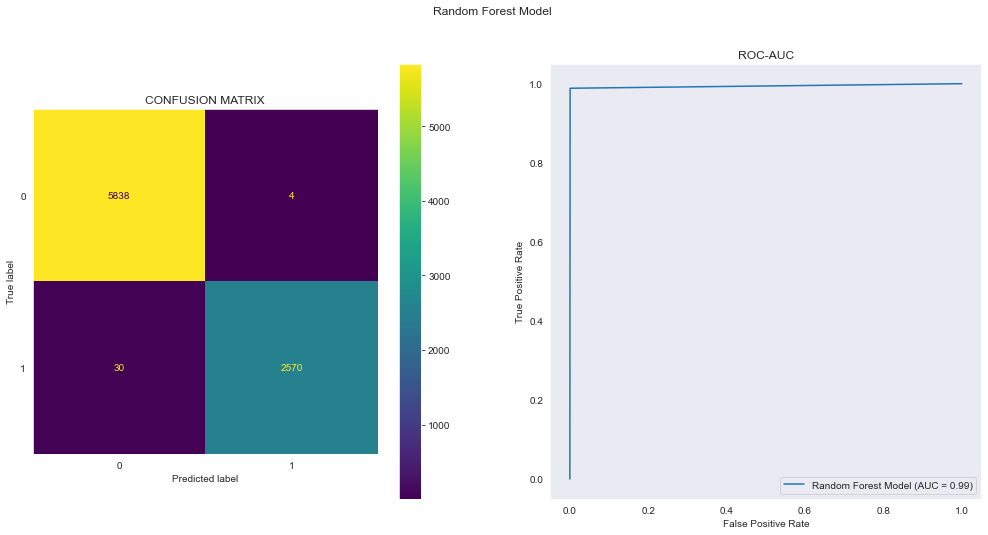

In [ ]:
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
RF_mdl = RandomForestClassifier()
RF_mdl.fit(X_tr_tfidf_vec, y_train)
evaluate_model(RF_mdl, train_data=X_tr_tfidf_vec, train_label=y_train, model_name='Random Forest Model')

Now we will do hyperparameter tuning using GridSearch CV 

In [ ]:
RF_mdl_gscv = RandomForestClassifier()
RF_param = {'n_estimators':(10,50,100,200,300), 'class_weight':(None, 'balanced', 'balanced_subsample')}
RF_clf_gscv = GridSearchCV(estimator = RF_mdl_gscv, param_grid = RF_param, n_jobs=-1, scoring='f1')
RF_clf_gscv.fit(X_tr_tfidf_vec, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': (None, 'balanced',
                                          'balanced_subsample'),
                         'n_estimators': (10, 50, 100, 200, 300)},
             scoring='f1')

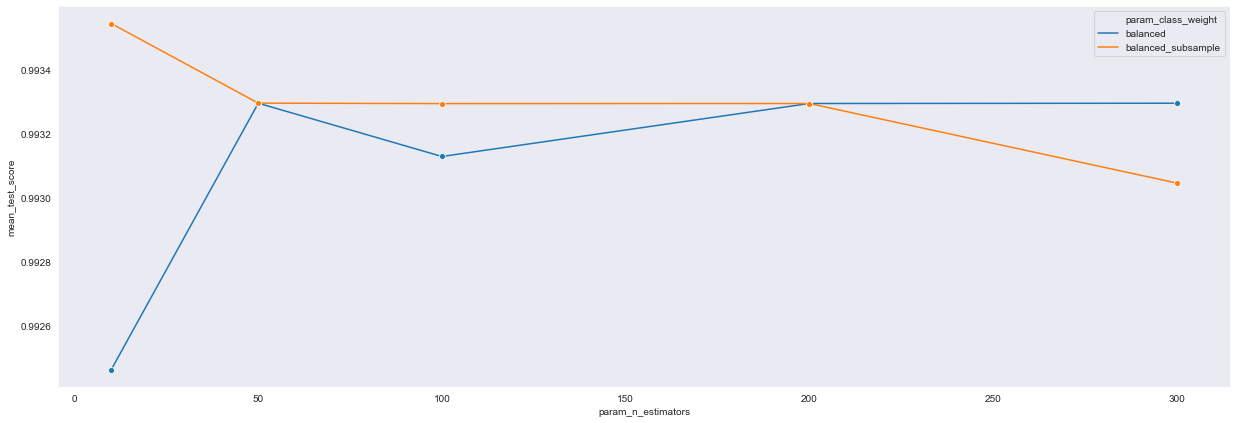

In [ ]:
RF_cv_results = pd.DataFrame(RF_clf_gscv.cv_results_)

fig = plt.figure(figsize=(21,7))
sns.lineplot(data = RF_cv_results , x='param_n_estimators', y='mean_test_score', hue='param_class_weight' ,marker="o")

Performance of  Random Forest is also good.

### Now we will apply GBDT model on sql injection data

Evaluating GBDT Model...
Classifier Training Accuracy =  99.18  %
Classifier Test Accuracy =  99.27  %
F1 Score for GBDT Model: 98.8 %
cross_validation f1-scores for GBDT Model 
 [0.98451548 0.98552894 0.984008  ]
roc_auc =  98.89


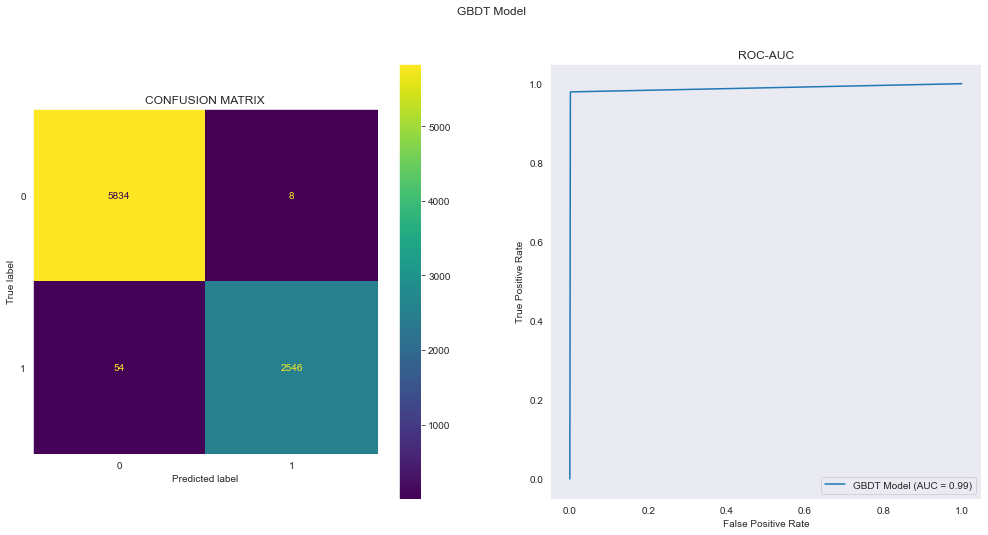

In [ ]:
GBDT_mdl = GradientBoostingClassifier()
GBDT_mdl.fit(X_tr_tfidf_vec, y_train)
evaluate_model(GBDT_mdl, train_data=X_tr_tfidf_vec, train_label=y_train, model_name='GBDT Model')

In [ ]:
GBDT_mdl_gscv = GradientBoostingClassifier()
GBDT_param = {'n_estimators':(50,100,200,300), 'learning_rate':(0.01, 0.1, 0.5, 1.0)}
GBDT_clf_gscv = GridSearchCV(estimator = GBDT_mdl_gscv , param_grid = GBDT_param, n_jobs=-1, scoring='f1')
GBDT_clf_gscv.fit(X_tr_tfidf_vec, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': (0.01, 0.1, 0.5, 1.0),
                         'n_estimators': (50, 100, 200, 300)},
             scoring='f1')

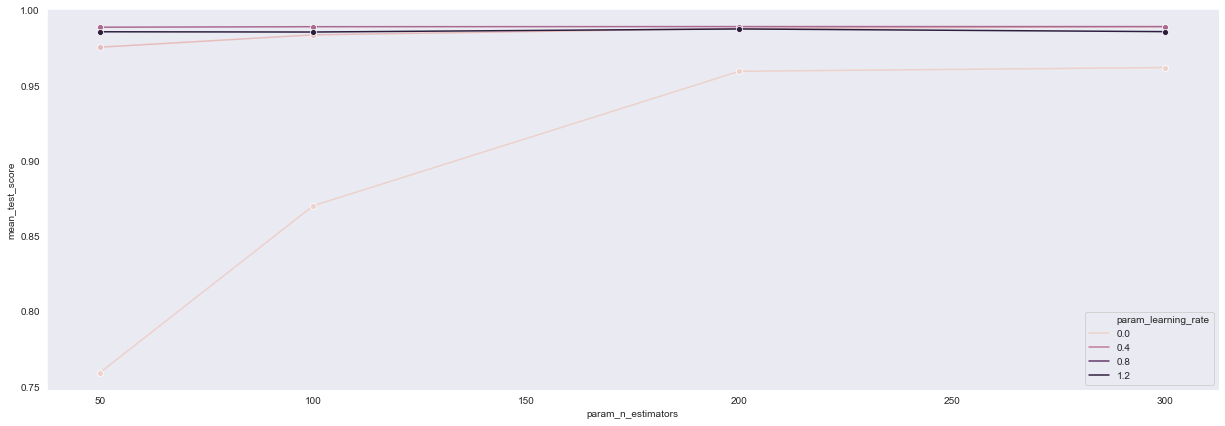

In [ ]:
GBDT_cv_results = pd.DataFrame(GBDT_clf_gscv.cv_results_)
fig = plt.figure(figsize=(21,7))
sns.lineplot(data = GBDT_cv_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate' ,marker="o")

Evaluating Tuned GBDT Model...
Classifier Training Accuracy =  99.7  %
Classifier Test Accuracy =  99.49  %
F1 Score for Tuned GBDT Model: 99.17 %
cross_validation f1-scores for Tuned GBDT Model 
 [0.98931677 0.98956781 0.98830555]
roc_auc =  99.25


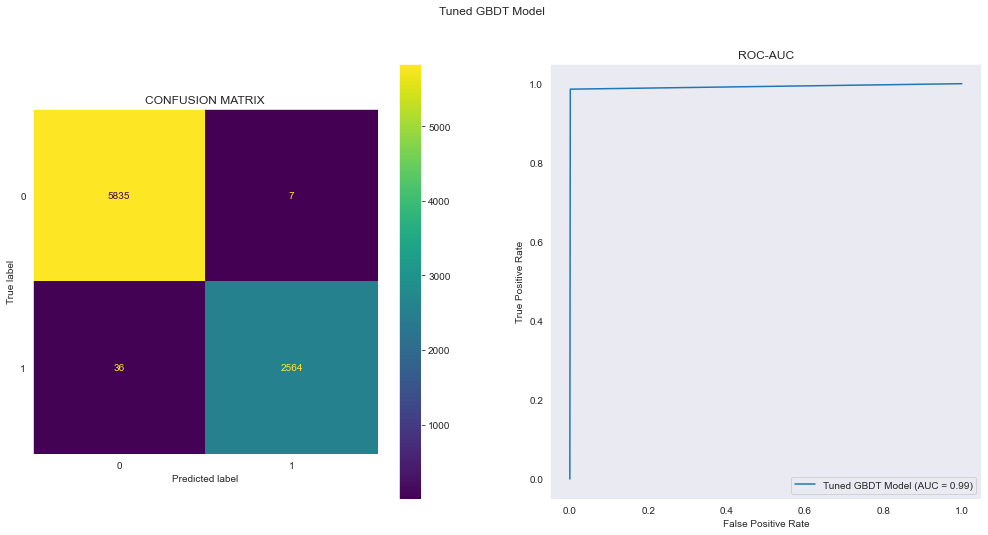

In [ ]:
tuned_GBDT_mdl = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300)
tuned_GBDT_mdl.fit(X_tr_tfidf_vec, y_train)
evaluate_model(tuned_GBDT_mdl, train_data=X_tr_tfidf_vec, train_label=y_train, model_name='Tuned GBDT Model')

As compared to RF model, GBDT's performance is inferior

### SVM model

Evaluating SVM Model...
Classifier Training Accuracy =  99.74  %
Classifier Test Accuracy =  99.61  %
F1 Score for SVM Model: 99.36 %
cross_validation f1-scores for SVM Model 
 [0.99128269 0.99279145 0.99054256]
roc_auc =  99.39


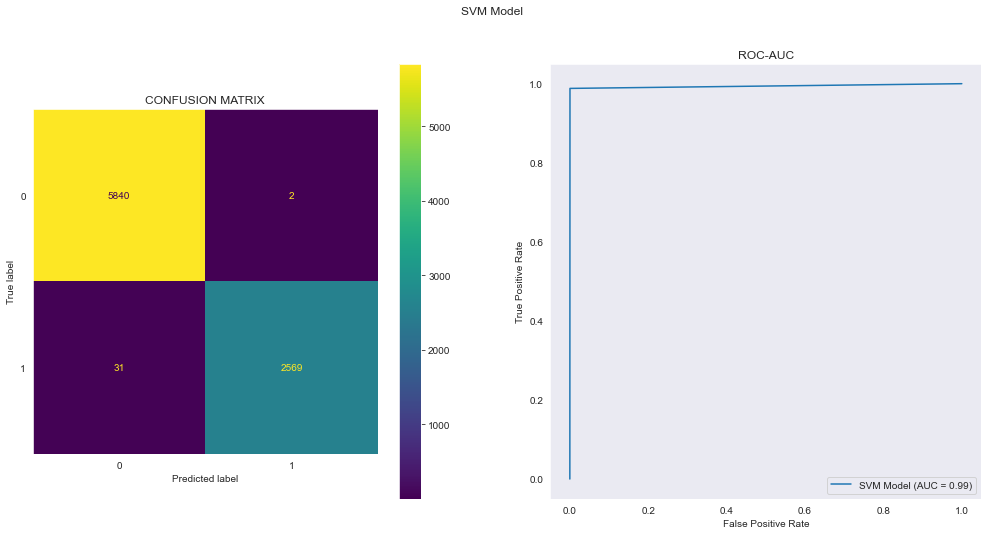

In [ ]:
SVM_mdl = SVC()
SVM_mdl.fit(X_tr_tfidf_vec, y_train)
evaluate_model(SVM_mdl, train_data=X_tr_tfidf_vec, train_label=y_train, model_name='SVM Model')

In [ ]:
GridSearchCV(estimator=SVC(), n_jobs=-1,param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0),'kernel': ('linear', 'rbf')},scoring='f1')

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0),
                         'kernel': ('linear', 'rbf')},
             scoring='f1')

In [ ]:
SVM_mdl_gscv = SVC()
SVM_param = {'kernel':('linear', 'rbf'), 'C':(0.1, 0.5, 1.0, 5.0, 10.0)}
SVM_clf_gscv = GridSearchCV(estimator = SVM_mdl_gscv , param_grid = SVM_param, n_jobs=-1, scoring='f1')
SVM_clf_gscv.fit(X_tr_tfidf_vec, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0),
                         'kernel': ('linear', 'rbf')},
             scoring='f1')

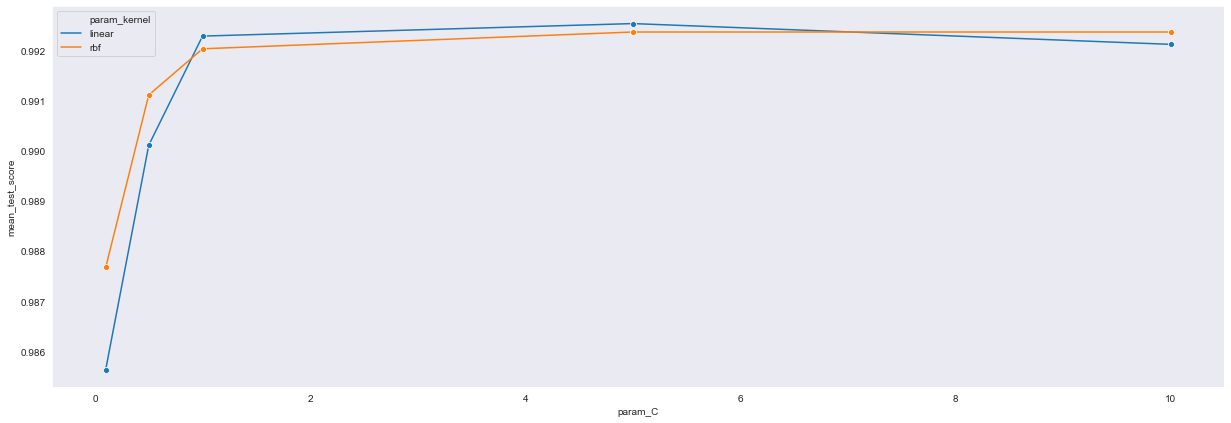

In [ ]:
SVM_cv_results = pd.DataFrame(SVM_clf_gscv.cv_results_)
fig = plt.figure(figsize=(21,7))
sns.lineplot(data = SVM_cv_results, x='param_C', y='mean_test_score', hue='param_kernel' ,marker="o")


Evaluating Tuned SVM Model...
Classifier Training Accuracy =  99.71  %
Classifier Test Accuracy =  99.62  %
F1 Score for Tuned SVM Model: 99.38 %
cross_validation f1-scores for Tuned SVM Model 
 [0.98979846 0.99304521 0.99080745]
roc_auc =  99.42


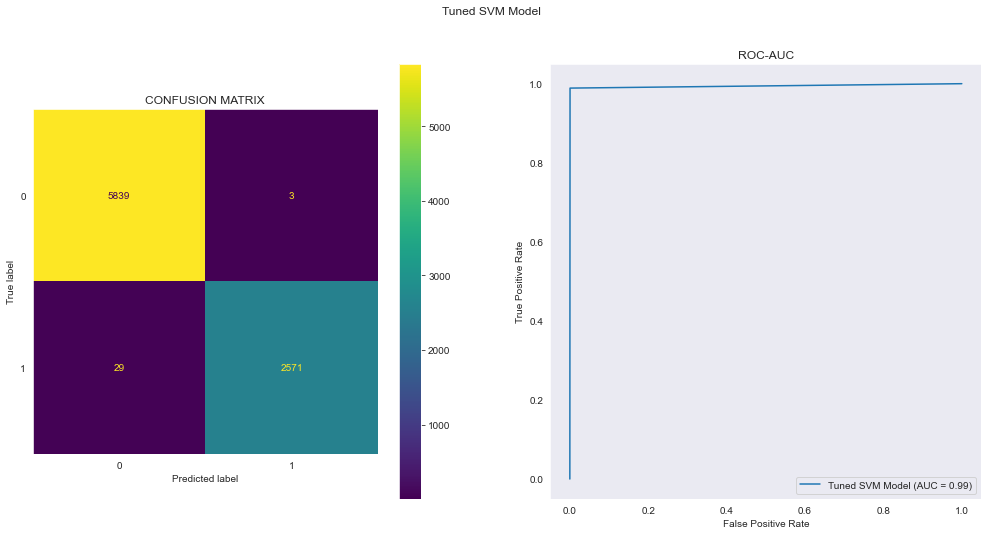

In [ ]:
tuned_SVM_mdl = SVC(kernel='linear', C=5.0)
tuned_SVM_mdl.fit(X_tr_tfidf_vec, y_train)
evaluate_model(tuned_SVM_mdl, train_data=X_tr_tfidf_vec, train_label=y_train, model_name='Tuned SVM Model')

## Naive Bayes Model on sql injection data

In [ ]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
naive_bayes_mdl = MultinomialNB()
naive_bayes_mdl.fit(X_tr_tfidf_vec, y_train)

MultinomialNB()

Evaluating Naive Bayes Model...
Classifier Training Accuracy =  95.88  %
Classifier Test Accuracy =  95.51  %
F1 Score for Naive Bayes Model: 92.35 %
cross_validation f1-scores for Naive Bayes Model 
 [0.92364017 0.93451143 0.92440945]
roc_auc =  93.43


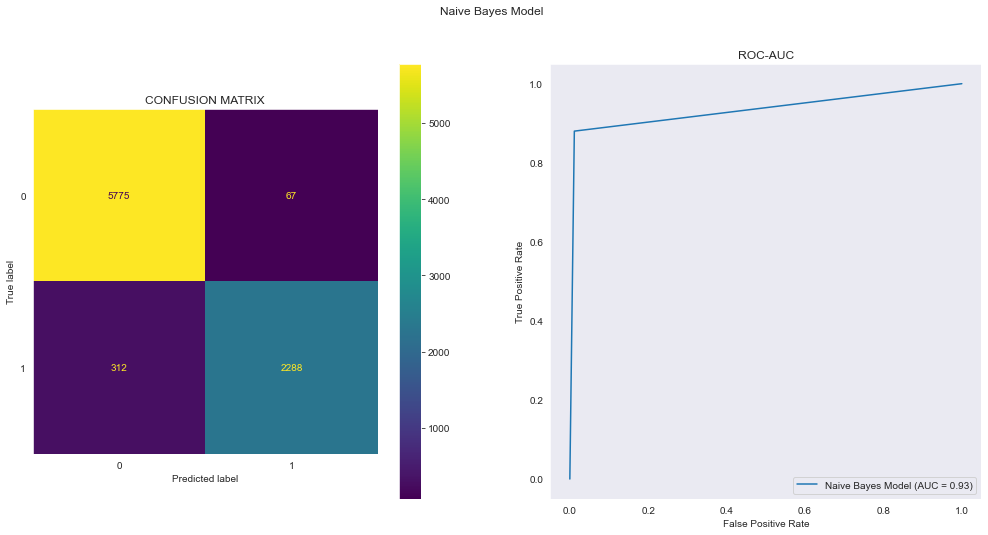

In [ ]:
#calling our function for checking the accuracy of the NB model
evaluate_model(naive_bayes_mdl, train_data=X_tr_tfidf_vec, train_label=y_train, model_name='Naive Bayes Model')

### Now using GridsearchCV for hyperparameter optimization for Naive Bayes

In [ ]:
naive_bayes_mdl_gscv = MultinomialNB()
naive_bayes_params = {'alpha':(0, 0.1, 0.5, 1, 10, 100, 500)}

In [ ]:
naive_bayes_clf = GridSearchCV(estimator = naive_bayes_mdl_gscv, param_grid = naive_bayes_params, n_jobs=-1, scoring='f1')

In [ ]:
naive_bayes_clf.fit(X_tr_tfidf_vec, y_train)


C:\Users\ankit\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (0, 0.1, 0.5, 1, 10, 100, 500)},
             scoring='f1')

In [ ]:
Naïve_bayes_cv_rslt = pd.DataFrame(naive_bayes_clf.cv_results_)

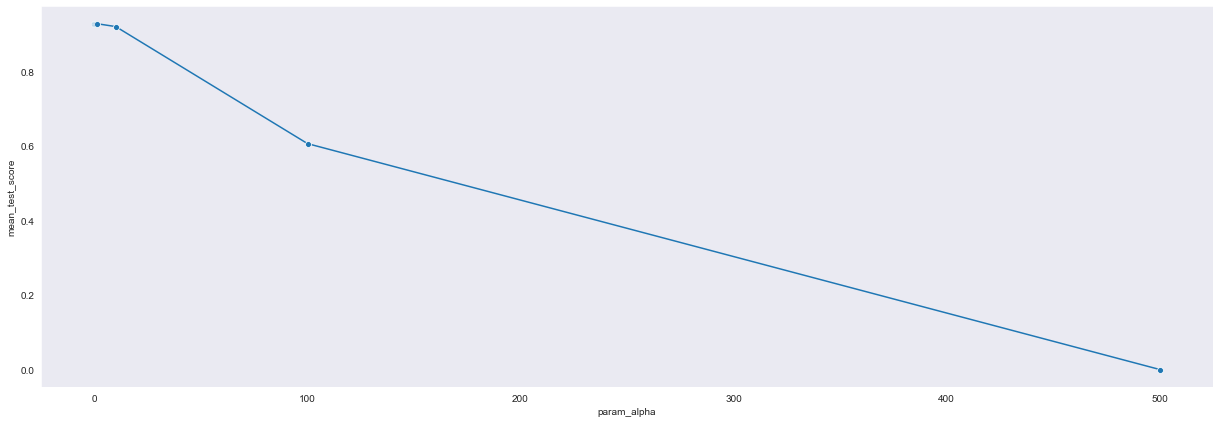

In [ ]:
fig = plt.figure(figsize=(21,7))
sns.lineplot(data =Naïve_bayes_cv_rslt , x='param_alpha', y='mean_test_score', marker="o")

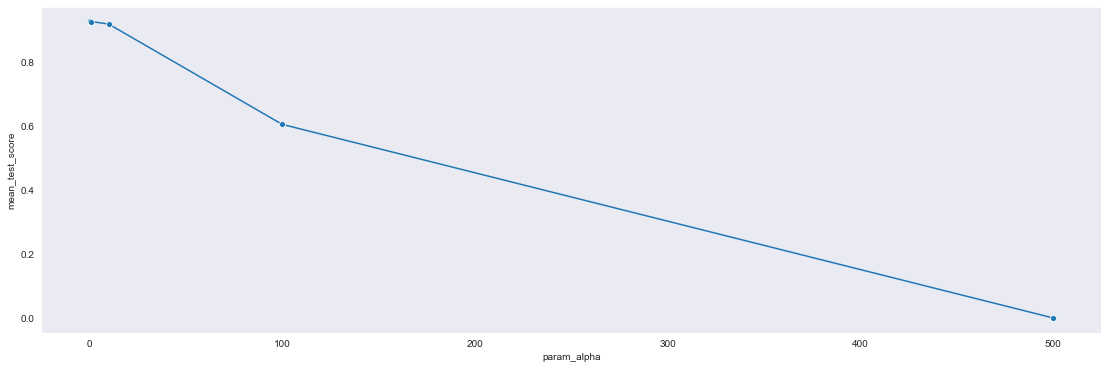

In [ ]:
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = Naïve_bayes_cv_rslt, x='param_alpha', y='mean_test_score', marker="o")

In [ ]:
# Saving cleaned dataset for  reusability
final_dataset = (X_tr_tfidf_vec, X_te_tfidf_vec, y_train, y_test)
with open('./final_dataset.sav', 'wb') as file:
      pickle.dump(final_dataset, file)

In [ ]:
final_RF_mdl = RandomForestClassifier(n_estimators=50, class_weight='balanced')
final_RF_mdl.fit(X_tr_tfidf_vec, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50)

In [ ]:
#final model, as we have seen RF model is giving best outputs
with open('./final_RF_mdl.model', 'wb') as file:
      pickle.dump(final_RF_mdl, file)

In [ ]:
myTable = PrettyTable(["Model Name", "ROC"])

In [ ]:
myTable.add_row(["k-NN", "99.49%"])
myTable.add_row(["Logistic Regression","99.59%"])
myTable.add_row(["Naive Bayes","95.51%"])
myTable.add_row(["SVM"," 99.23 %"])
myTable.add_row(["Random Forest","99.61%"])
myTable.add_row(["GBDT","99.27%"])

In [ ]:
print(myTable)

+---------------------+----------+
|      Model Name     |   ROC    |
+---------------------+----------+
|         k-NN        |  99.49%  |
| Logistic Regression |  99.59%  |
|     Naive Bayes     |  95.51%  |
|         SVM         |  99.23 % |
|    Random Forest    |  99.61%  |
|         GBDT        |  99.27%  |
+---------------------+----------+


In [ ]:
#reading the pickle file of final dataset as saved in the previous stage 03

final_data = pd.read_pickle('./final_dataset.sav')
X_train, X_test, y_train, y_test = final_data

## Creating some extra features to check if the efficiency of the model improves or not

Upon further reading I found that there could be more features that could be created based on the data. So creating new features and training RF model from our previous phase to see how it performs and will also try to incorporate these features when building Deep Learning models.


Since most of the malacious queries have special characters and numbers in them let's see by adding them as new features des our model improve. So adding the following features and re-checking the accuracy of our **Random Forest model**.
 
 The features are:
 
**Length of the Query**  : Number of words in the query after removing special characters

**Count of Special Characters** : Number of special characters in the raw query

**Count of number=number pattern** : Number of times some **digit = digit** occurs in the query. like, 1=1

***We will train our RF model with 3 new added features and then Apply all our deep learning models***

In [ ]:
# Reading the cleaned and saved data file from 
with open('sqli_data_df.pkl', 'rb') as f:
    sqli_data = pickle.load(f)

In [ ]:
#USing a copy of the cleaned data set
FE_sqli_data = sqli_data.copy()

In [ ]:
# Impoting the raw data for counting sqecial characters and query length
raw_data = pd.read_csv("./Modified_SQL_Dataset.csv")

In [ ]:
import re

In [ ]:
#Applying map functions and cleaning using regex

num_of_spcl_chars = raw_data['Query'].map(lambda x:len(re.findall('[^a-zA-Z0-9\s]',x)))
qry_length = sqli_data['Query'].map(lambda x:len(x.split()))
no_of_eq_num = raw_data['Query'].map(lambda x:len(re.findall(r'\d\s*=\s*\d',x))).sort_values(ascending=False)

In [ ]:
#Creating new columns
FE_sqli_data['qry_len'] = qry_length
FE_sqli_data['num_eq_num'] = no_of_eq_num.loc[FE_sqli_data.index]
FE_sqli_data['num_spl_chr'] = num_of_spcl_chars.loc[FE_sqli_data.index]

In [ ]:
FE_sqli_data.head()

,Query,Label,qry_len,num_eq_num,num_spl_chr
0,or pg sleep time,1,4,0,10
1,create user name identified by pass123 tempora...,1,12,0,1
2,and 1 utl inaddr get host address select disti...,1,29,0,25
3,select from users where id 1 or 1 1 union sele...,1,14,1,13
4,select from users where id 1 or 1 union select...,1,13,0,10


In [ ]:
X = sqli_data['Query']
y = sqli_data['Label']

In [ ]:
#Splitting the data into test and train
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
#Using tfidf vectorizer 

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_tr_tfidf_vec = tfidf_vectorizer.fit_transform(X_tr)
X_te_tfidf_vec = tfidf_vectorizer.transform(X_te)

In [ ]:
X_test_tfidf_FE = X_te_tfidf_vec.copy()

In [ ]:
#Dumping new columns into our new data set for  feature engineering
X_tr_tfidf_FE = pd.DataFrame(data=X_tr_tfidf_vec.toarray(),columns=tfidf_vectorizer.get_feature_names(), index=X_tr.index)
X_tr_tfidf_FE['num_spl_chr'] = FE_sqli_data.loc[X_tr.index]['num_spl_chr']
X_tr_tfidf_FE['qry_len'] = FE_sqli_data.loc[X_tr.index]['qry_len']
X_tr_tfidf_FE['num_eq_num'] = FE_sqli_data.loc[X_tr.index]['num_eq_num']

In [ ]:
X_test_tfidf_FE = pd.DataFrame(data=X_te_tfidf_vec.toarray(),columns=tfidf_vectorizer.get_feature_names(), index= X_te.index)


In [ ]:
X_test_tfidf_FE.head()

,01,01 and,01 and 1996,06,06 15,06 15 09,07,07 01,07 01 and,07 31,...,xmltype chr,xmltype chr 60,yard,ydpu,ydpu and,year,yes,yourself,zipper,zulu
13356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test_tfidf_FE['num_spl_chr'] = FE_sqli_data.loc[X_te.index]['num_spl_chr']
X_test_tfidf_FE['qry_len'] = FE_sqli_data.loc[X_te.index]['qry_len']
X_test_tfidf_FE['num_eq_num'] = FE_sqli_data.loc[X_te.index]['num_eq_num']

### Training RF model with new features

In [ ]:
## https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
final_FE_RFC_model = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
final_FE_RFC_model.fit(X_tr_tfidf_FE, y_tr)

RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

Evaluating RFC model with New Feautres...
Training Accuracy of RF model with new features =  99.904  %
Testing Accuracy of RF model with new features =  99.763  %
F1 Score for RFC model with New Feautres: 99.614 %
cross_validation f1-scores for RFC model with New Feautres 

 [0.99479037 0.99305211 0.99429139]
ROC_AUC of our new model is =  99.637


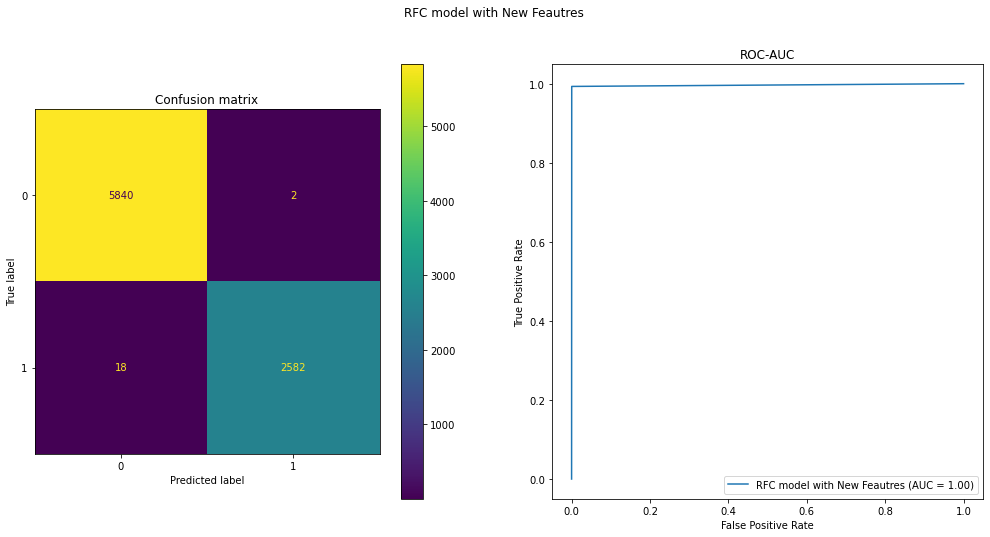

In [ ]:
### Evaluating our model with new features

model = final_FE_RFC_model
train_data=X_tr_tfidf_FE
train_label=y_train
model_name='RFC model with New Feautres'


print(f'Evaluating {model_name}...')
train_acc_score = model.score(train_data, train_label)
test_acc_score = model.score(X_test_tfidf_FE, y_test)

print('Training Accuracy of RF model with new features = ',round(train_acc_score*100, 3), ' %')
print('Testing Accuracy of RF model with new features = ',round(test_acc_score*100, 3), ' %')

y_predictions = model.predict(X_test_tfidf_FE)
print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,3)} %")
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

cross_val_f1 = cross_val_score(model, train_data, train_label, cv=3, scoring='f1')
print(f'cross_validation f1-scores for {model_name} \n\n {cross_val_f1}')

fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("ROC_AUC of our new model is = ", round(roc_auc*100,3))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(17,8))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confusion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);

There is a slight improvement in the model accuracy after adding our new features.

In [ ]:
## Saving our final model for future reusability

with open('./final_FE_RFC_model.model', 'wb') as file:
     pickle.dump(final_FE_RFC_model, file)

In [ ]:
#https://github.com/tungpv98/Detect-Sql-Injection-by-Machine-Learning/blob/ebeb3287931677a3a42f11a7a08dbc13e374ff05/Sql-Injection/source/ml_detect_sqli.py
#https://github.com/12nandini/Malicious_SQLI_detection/blob/main/Malicious_SQL_Attack_Detection.ipynb
#https://www.kaggle.com/code/amanrajput27/nlp-project-applying-bert-on-sql-injection-data/notebook?scriptVersionId=80815903

data_FE = (X_tr_tfidf_FE, X_test_tfidf_FE, y_train, y_test)
with open('./data_FE.sav', 'wb') as file:
    pickle.dump(data_FE, file)

### Applying Advanced Deep Learning Models

### Multi Layered Perceptron

In [ ]:
#reading the final featured enginnered file saved previously

dat_FE = pd.read_pickle('./data_FE.sav')
X_train, X_test, y_train, y_test = data_FE

In [ ]:
##https://scikit-learn.org/stable/modules/neural_networks_supervised.html
MLP_mdl =  MLPClassifier()
MLP_mdl.fit(X_train, y_train)


MLPClassifier()

In [ ]:
#https://towardsdatascience.com/ultimate-function-for-classification-82f1fc711ab9
#https://realpython.com/python-eval-function/


def evaluate_model(model, train_data, train_label, model_name = 'Model', cv=3):
    print(f'Evaluating {model_name}...')
    global X_test
    global y_test
    train_accuracy_score = model.score(train_data, train_label)
    test_accuracy_score = model.score(X_test, y_test)
  
    print('Classifier Training Accuracy = ',round(train_accuracy_score*100, 2), ' %')
    print('Classifier Test Accuracy = ',round(test_accuracy_score*100, 2), ' %')
  
    y_predictions = model.predict(X_test)
    print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,2)} %")
    confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

    cross_val_f1 = cross_val_score(model, train_data, train_label, cv=cv, scoring='f1')
    print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

    fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
    print("roc_auc = ", round(roc_auc*100,2))

    figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(17,8))
    confusion_mat.plot(ax=ax1)
    ax1.set_title('CONFUSION MATRIX')
    roc_display.plot(ax=ax2)
    ax2.set_title('ROC-AUC')
    figure.suptitle(model_name)

Evaluating Multilayer Perceptron...
Classifier Training Accuracy =  99.76  %
Classifier Test Accuracy =  99.61  %
F1 Score for Multilayer Perceptron: 99.36 %
cross_validation f1-scores for Multilayer Perceptron 
 [0.99004975 0.99205166 0.99155909]
roc_auc =  99.4


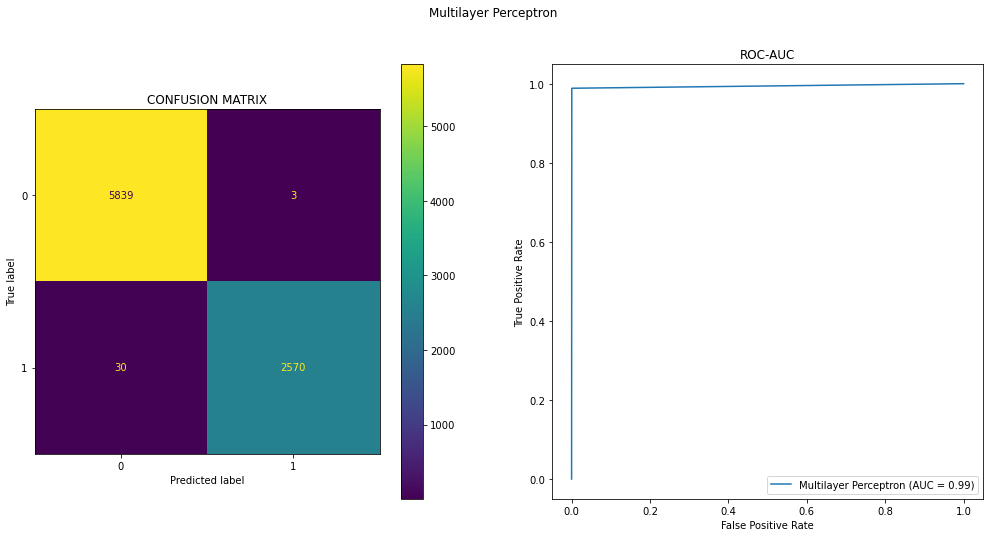

In [ ]:
evaluate_model(MLP_mdl, train_data=X_train, train_label=y_train, model_name='Multilayer Perceptron')

#### Now checking for various hidden layer sizes

In [ ]:
##https://scikit-learn.org/stable/modules/neural_networks_supervised.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
MLP_mdl_gscv = MLPClassifier()
MLP_params = {'hidden_layer_sizes':((50,),(100,),(200,),(300,),(500,200,))}
MLP_clsf_gscv = GridSearchCV(estimator = MLP_mdl_gscv, param_grid = MLP_params, n_jobs=-1, scoring='f1')
MLP_clsf_gscv.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'hidden_layer_sizes': ((50,), (100,), (200,), (300,),
                                                (500, 200))},
             scoring='f1')

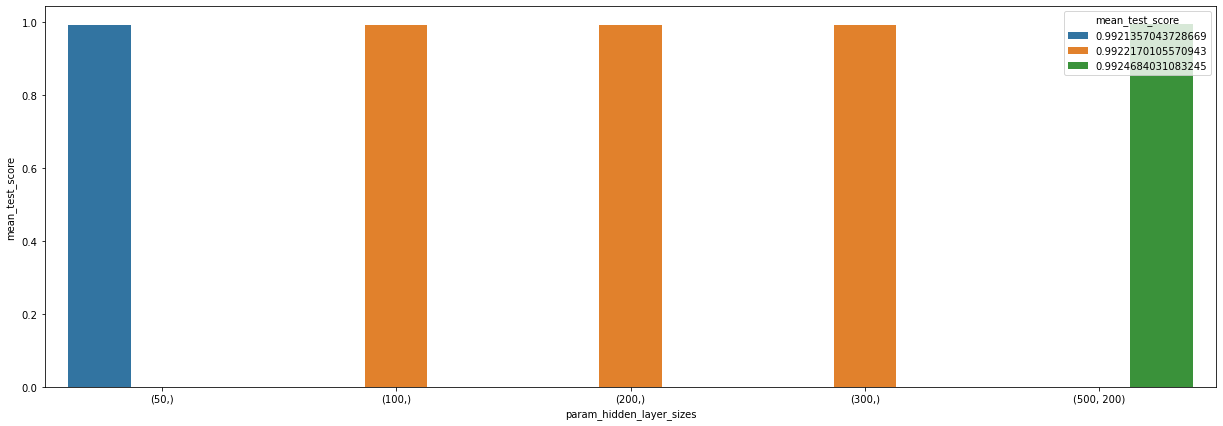

In [ ]:
MLP_cv_rslt = pd.DataFrame(MLP_clsf_gscv.cv_results_)

fig = plt.figure(figsize=(21,7))
sns.barplot(data = MLP_cv_rslt, x='param_hidden_layer_sizes', y='mean_test_score', hue='mean_test_score')



#### Accuracy for Layer size of 300 seems to be optimum, layer of 500, 200 might overfit.

Evaluating Tuned MLP Model ...
Classifier Training Accuracy =  99.77  %
Classifier Test Accuracy =  99.61  %
F1 Score for Tuned MLP Model : 99.36 %
cross_validation f1-scores for Tuned MLP Model  
 [0.99030092 0.99204771 0.99155909]
roc_auc =  99.41


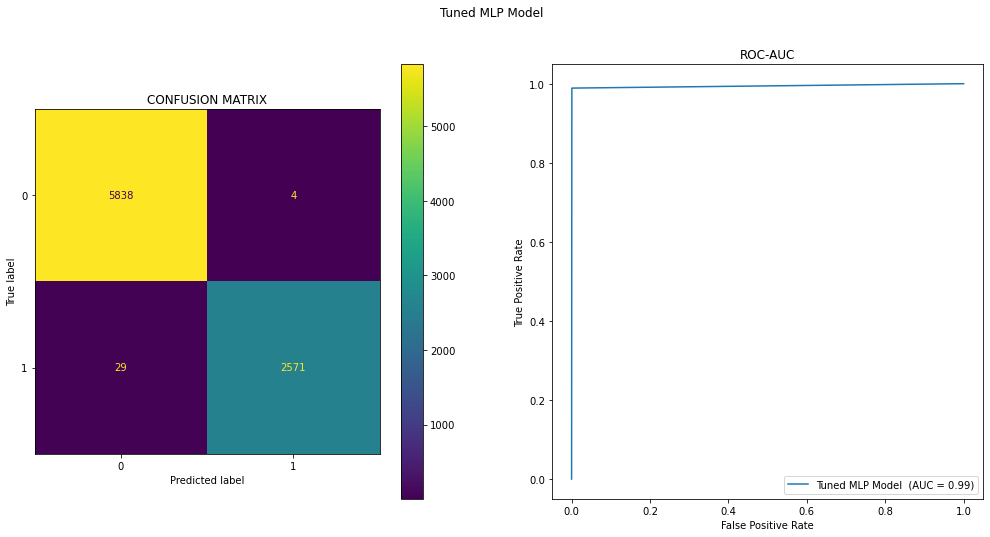

In [ ]:
tuned_MLP_model = MLPClassifier(hidden_layer_sizes=(300,))
tuned_MLP_model.fit(X_train, y_train)
evaluate_model(tuned_MLP_model, train_data=X_train, train_label=y_train, model_name='Tuned MLP Model ')

In [ ]:
# defining the model

# define the model
model = Sequential()
model.add(Dense(250, input_shape=(2503,)))
model.add(Dense(125))
model.add(Dense(55))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=12,
                    validation_data=(X_test, y_test),
                    validation_steps=50)

Epoch 1/12
616/616 [==============================] - 7s 8ms/step - loss: 0.1600 - accuracy: 0.9444 - val_loss: 0.0339 - val_accuracy: 0.9918
Epoch 2/12
616/616 [==============================] - 5s 8ms/step - loss: 0.0291 - accuracy: 0.9925 - val_loss: 0.0239 - val_accuracy: 0.9950
Epoch 3/12
616/616 [==============================] - 5s 8ms/step - loss: 0.0240 - accuracy: 0.9946 - val_loss: 0.0227 - val_accuracy: 0.9948
Epoch 4/12
616/616 [==============================] - 5s 7ms/step - loss: 0.0207 - accuracy: 0.9952 - val_loss: 0.0236 - val_accuracy: 0.9954
Epoch 5/12
616/616 [==============================] - 5s 8ms/step - loss: 0.0206 - accuracy: 0.9956 - val_loss: 0.0206 - val_accuracy: 0.9959
Epoch 6/12
616/616 [==============================] - 5s 8ms/step - loss: 0.0190 - accuracy: 0.9959 - val_loss: 0.0206 - val_accuracy: 0.9959
Epoch 7/12
616/616 [==============================] - 5s 7ms/step - loss: 0.0169 - accuracy: 0.9963 - val_loss: 0.0205 - val_accuracy: 0.9960
Epoch 

Model has achieved good accuracy on test and validation dataset

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

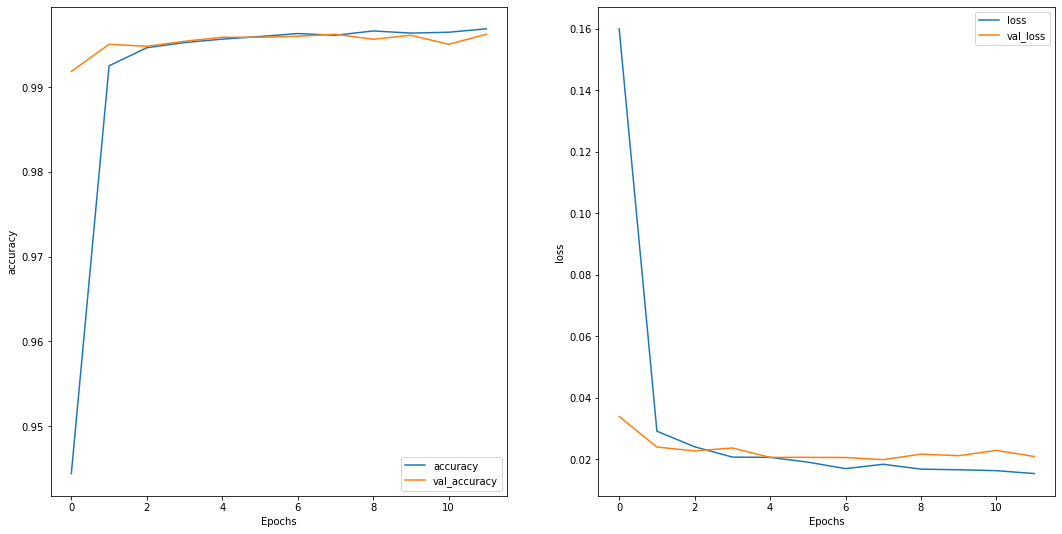

In [ ]:
#drawing the plot
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

### Using Keras Model

In [ ]:
train_data=X_train
train_label=y_train
model_name='Feature engineered tuned MLP(keras) Model'

print(f'Evaluating {model_name}...')
train_acc_score = model.evaluate(train_data, train_label);
test_acc_score = model.evaluate(X_test, y_test);

print('Training Accuracy = ',round(train_acc_score[1]*100, 3), ' %')
print('Testing Accuracy = ',round(test_acc_score[1]*100, 3), ' %')

y_predictions = (model.predict(X_test) > 0.5).astype("int32")
print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,3)} %")

Evaluating Feature engineered Keras Model...
264/264 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.9962
Training Accuracy =  99.716  %
Testing Accuracy =  99.621  %
264/264 [==============================] - 1s 3ms/step
F1 Score for Feature engineered Keras Model: 99.382 %


roc_auc =  99.427


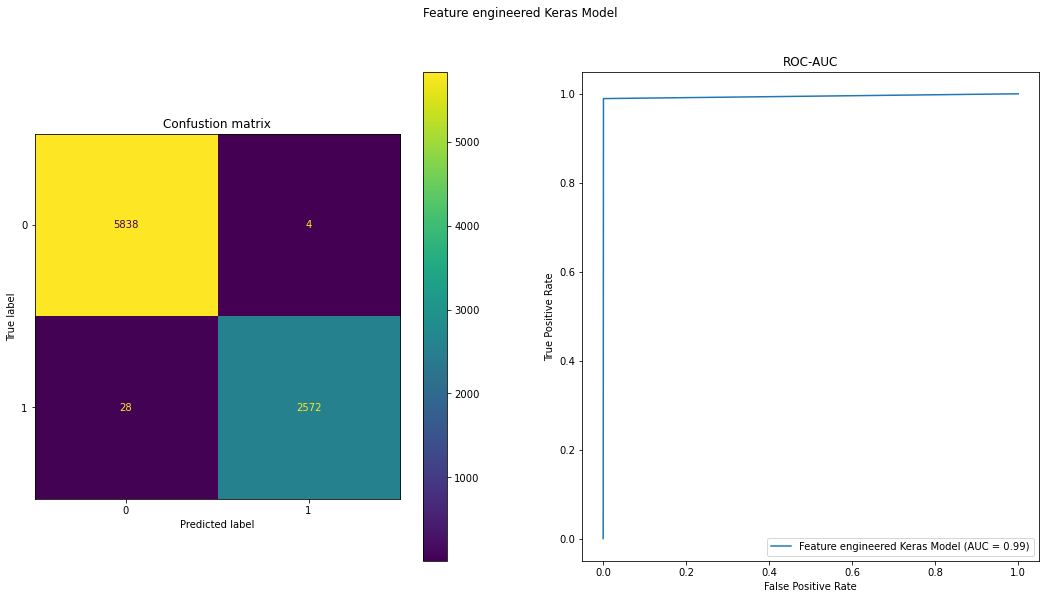

In [ ]:
#Displaying the confusion Matrix

confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,3))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(18,9))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);

Since default optimizers in Sklearn is Adam, and there are different optimizers available in different libraries, we will use different optimizers like:


1. Look Ahead Optimizer: https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/Lookahead
2. AdaBelief Optimizer: https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdaBelief
3. Adabelief with LookAhead Optimizer :https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdaBelief


and analyse results, the above optimizers are available in Tensorflow addons library


### Using LookAhead optimizer

In [ ]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers
opt = tf.keras.optimizers.Adam(1e-4)
opt = tfa.optimizers.Lookahead(opt)

In [ ]:
#https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
#https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers
history = model.fit(X_train, y_train, epochs=12,
                    validation_data=(X_test, y_test),
                    validation_steps=50)

Epoch 1/12
616/616 [==============================] - 10s 12ms/step - loss: 0.0142 - accuracy: 0.9971 - val_loss: 0.0210 - val_accuracy: 0.9962
Epoch 2/12
616/616 [==============================] - 6s 10ms/step - loss: 0.0139 - accuracy: 0.9969 - val_loss: 0.0223 - val_accuracy: 0.9959
Epoch 3/12
616/616 [==============================] - 7s 11ms/step - loss: 0.0136 - accuracy: 0.9970 - val_loss: 0.0225 - val_accuracy: 0.9960
Epoch 4/12
616/616 [==============================] - 6s 10ms/step - loss: 0.0132 - accuracy: 0.9972 - val_loss: 0.0241 - val_accuracy: 0.9949
Epoch 5/12
616/616 [==============================] - 6s 10ms/step - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.0223 - val_accuracy: 0.9962
Epoch 6/12
616/616 [==============================] - 6s 10ms/step - loss: 0.0136 - accuracy: 0.9971 - val_loss: 0.0243 - val_accuracy: 0.9956
Epoch 7/12
616/616 [==============================] - 7s 11ms/step - loss: 0.0127 - accuracy: 0.9974 - val_loss: 0.0267 - val_accuracy: 0.995

We see that although LookAhead takes little bit more time than Adam optimizer but gives a little more accuracy from first epoch itself.

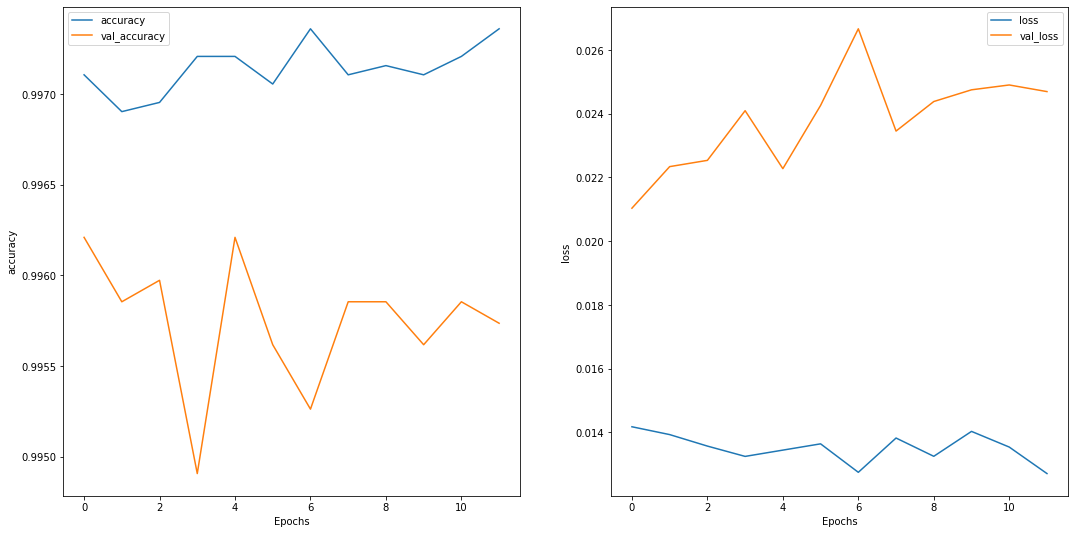

In [ ]:
#Drawing the plot
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## AdaBelief Optimizer

In [ ]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers

opt_AdaBelief = tfa.optimizers.AdaBelief(learning_rate=1e-4)

In [ ]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=opt_AdaBelief,
              metrics=['accuracy'])

In [ ]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers

history = model.fit(X_train, y_train, epochs=12,
                    validation_data=(X_test, y_test),
                    validation_steps=50)

Epoch 1/12
616/616 [==============================] - 12s 15ms/step - loss: 0.0122 - accuracy: 0.9973 - val_loss: 0.0243 - val_accuracy: 0.9959
Epoch 2/12
616/616 [==============================] - 9s 14ms/step - loss: 0.0139 - accuracy: 0.9971 - val_loss: 0.0252 - val_accuracy: 0.9956
Epoch 3/12
616/616 [==============================] - 11s 17ms/step - loss: 0.0130 - accuracy: 0.9972 - val_loss: 0.0241 - val_accuracy: 0.9960
Epoch 4/12
616/616 [==============================] - 10s 16ms/step - loss: 0.0141 - accuracy: 0.9969 - val_loss: 0.0266 - val_accuracy: 0.9957
Epoch 5/12
616/616 [==============================] - 10s 16ms/step - loss: 0.0136 - accuracy: 0.9972 - val_loss: 0.0287 - val_accuracy: 0.9957
Epoch 6/12
616/616 [==============================] - 10s 17ms/step - loss: 0.0145 - accuracy: 0.9973 - val_loss: 0.0255 - val_accuracy: 0.9956
Epoch 7/12
616/616 [==============================] - 10s 16ms/step - loss: 0.0143 - accuracy: 0.9972 - val_loss: 0.0260 - val_accuracy: 

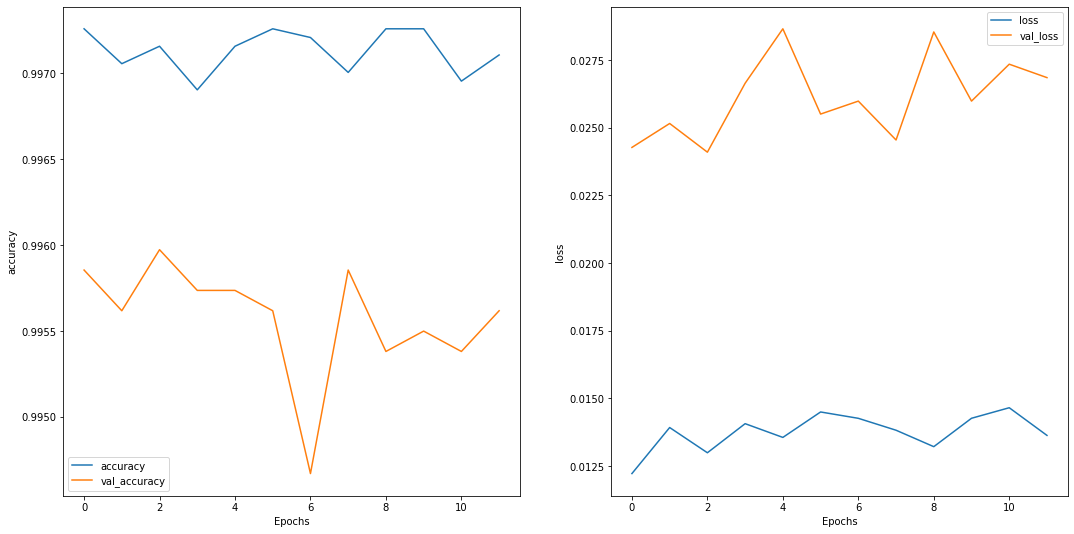

In [ ]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

AdaBelief is also giving the same accuracy as LookAhead and slightly better than Adam optimizer 


### Adabelief with LookAhead optimizer

In [ ]:
#https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers
adabelief = tfa.optimizers.AdaBelief()
ranger = tfa.optimizers.Lookahead(adabelief, sync_period=6, slow_step_size=0.5)

In [ ]:
#https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=ranger,
              metrics=['accuracy'])

In [ ]:
#https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers

history = model.fit(X_train, y_train, epochs=12,
                    validation_data=(X_test, y_test),
                    validation_steps=50)

Epoch 1/12
616/616 [==============================] - 16s 20ms/step - loss: 0.0160 - accuracy: 0.9968 - val_loss: 0.0326 - val_accuracy: 0.9937
Epoch 2/12
616/616 [==============================] - 12s 20ms/step - loss: 0.0193 - accuracy: 0.9961 - val_loss: 0.0475 - val_accuracy: 0.9835
Epoch 3/12
616/616 [==============================] - 12s 20ms/step - loss: 0.0157 - accuracy: 0.9966 - val_loss: 0.0249 - val_accuracy: 0.9959
Epoch 4/12
616/616 [==============================] - 12s 20ms/step - loss: 0.0158 - accuracy: 0.9968 - val_loss: 0.0248 - val_accuracy: 0.9946
Epoch 5/12
616/616 [==============================] - 12s 20ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 0.0250 - val_accuracy: 0.9960
Epoch 6/12
616/616 [==============================] - 12s 20ms/step - loss: 0.0161 - accuracy: 0.9971 - val_loss: 0.0229 - val_accuracy: 0.9960
Epoch 7/12
616/616 [==============================] - 13s 22ms/step - loss: 0.0181 - accuracy: 0.9958 - val_loss: 0.0250 - val_accuracy:

We see that **adabelief** optimizers is performing a bit inferior to LookAhead optimizer but comparable to Adam optimizer, but takes double time compared to Adam optimizer

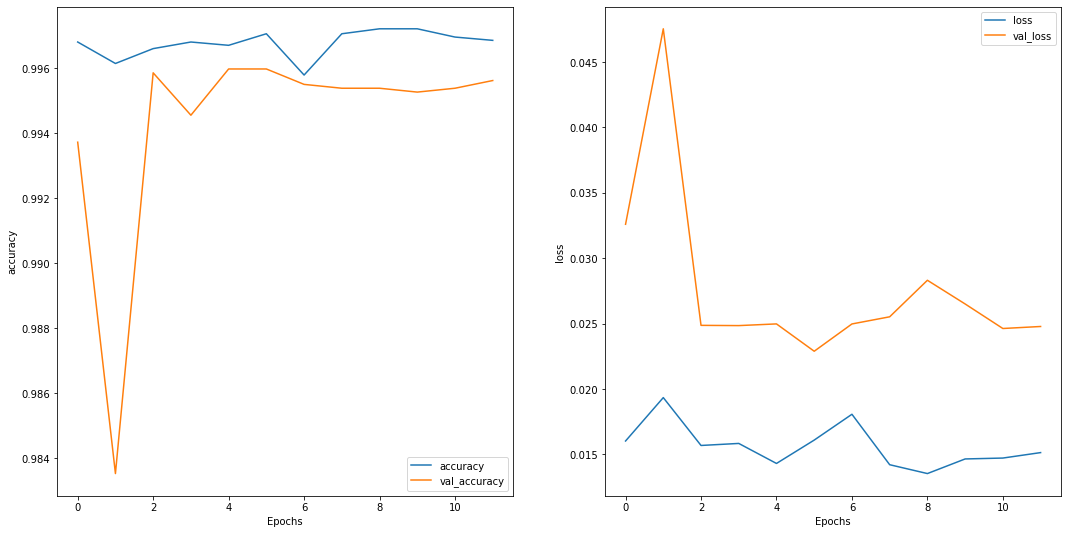

In [ ]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

So of all the models **Random Forest** model gives the best accuracy

In [ ]:
# To load the pickled model and vectorizer
_CWD = os.path.abspath(".")


# Load the pickled vectorizer and model
final_RFC_FE_model_file = _CWD+'/final_RFC_FE_model.model'	# generate path of model agnostic to OS
tfidf_vec_file = _CWD+'/tfidf_vec.sav' # generate path of vectorizer agnostic to OS


# If the model and vectorizer are not already present, download them
if not os.path.isfile(final_RFC_FE_model_file): # If the model is not present
    url = r'https://github.com/curi-adi/sql_injection_detection_using_ML/blob/main/final_FE_RFC_model.model' # URL of the model
    resp = requests.get(url)														# Download the model
    with open(final_RFC_FE_model_file, 'wb') as fopen:	# Open the file to write the model
        fopen.write(resp.content)												# Write the model

if not os.path.isfile(tfidf_vec_file):					# If the vectorizer is not present
    url = r'https://github.com/curi-adi/sql_injection_detection_using_ML/blob/main/tfidf_vec.sav'	# URL of the vectorizer
    resp = requests.get(url)														# Download the vectorizer
    with open(tfidf_vec_file, 'wb') as fopen:						# Open the file to write the vectorizer
        fopen.write(resp.content)												# Write the vectorizer


with open(final_RFC_FE_model_file, 'rb') as file:
	RFC_FE_model = pickle.load(file)
with open(tfidf_vec_file, 'rb') as file:
	TFIDF_vectorizer = pickle.load(file)

def clean_query(input_string):
	"""
	This function cleans the query by removing special characters and spaces.
	It also converts the query to lower case.
	input_string: string
	return: string
	"""
	cleaned = re.sub('[^a-zA-Z0-9\s]',' ',input_string)	# Remove special characters
	cleaned = re.sub('\s{2,}',' ',cleaned)							# Remove multiple spaces
	return cleaned.lower().strip()											# Convert the query to lower case and remove the leading and trailing spaces

def predict_probab(X_query):
	"""
	This function predicts the probability of the query being a SQLi attack.
	input: string
	Output: numpy array
	"""
	cleaned_query = clean_query(X_query)
 # Count the number of special characters
	no_of_special_chars = len(re.findall('[^a-zA-Z0-9\s]',X_query)) 
 # Count the number of words in the query
	query_length = len(X_query.split())			
 # Count the pattern of number = number												
	no_of_num_eq_num = len(re.findall(r'\d\s*=\s*\d',X_query))	
 		# Transform the query into a vector		
	X_q = TFIDF_vectorizer.transform([cleaned_query])	
 # Convert the vector to a dataframe					
	X_q_tfidf_FE = pd.DataFrame(data=X_q.toarray(),columns=TFIDF_vectorizer.get_feature_names_out()) 
  	# Add the number of special characters to the dataframe
	X_q_tfidf_FE['num_sc'] = no_of_special_chars
  	# Add the number of words to the dataframe									
	X_q_tfidf_FE['q_len'] = query_length		
  	# Add the number of pattern of number = number to the dataframe											
	X_q_tfidf_FE['num_eq_num'] = no_of_num_eq_num	
  	# Predict the probability of the query being a SQL injection attack								
	proba = RFC_FE_model.predict_proba(X_q_tfidf_FE)
 	# Return the probability of the query being a SQL injection attack							
	return proba[0]																								

def predict_class(X_q_obj, prob=False):
	"""
	This function predicts the class of the query if it is malicious or not.
	if prob is set to True, it returns the probability of the query being a SQLi attack.
	input: X_q_obj: string, prob: boolean
	output: boolean or numpy array
	"""
  	# If the input is a list
	if isinstance(X_q_obj,list):			
		proba = []
		for x in X_q_obj:
			proba.append(predict_probab(x))
   	# Return the numpy array of probabilities
		return np.array(proba)
  					
	# If the input is a string
	if isinstance(X_q_obj, str):			
    	# Predict the probability of the query being a SQL injection attack
		proba = predict_probab(X_q_obj)	
  # Return the class of the query
		class_ = np.argmax(proba)					
		if prob:									
      	# If the prob = True, Return the probability value
			return proba			
      # If the prob = False,Return the class of the query							
		else:															
			return class_

import streamlit as st
from prediction_module import predict_class

st.set_page_config(page_title="SQL Injection Detection", page_icon = '🧊')	# Set the page title and icon

st.title("SQL Injection Detection")																																			# Set the title of the page
st.text("""This page is used to detect SQL Injection attacks.																						
Please enter the SQL query in the text box below to detect if this query is a malacious query.""")	# Set the text of the page

st.header("Enter SQL query")												# Set the header of the page
with st.form("SQL injection Detection"):											# Create a form with name "SQLi Detection"
		query = st.text_input("Enter SQL query here")		# Create a text input with name "Enter SQL query here"
		if st.form_submit_button("Submit"):							# if the user clicks the submit button
			isSQLi = predict_class(query)									# Call the predict_class function and store the result in isSQLi
			st.write("Your query is:", query)							# Write the query in the text box
			if isSQLi:																		# If the query is a SQLi attack
				st.write("This query is Malacious")						# Write "This query is Malacious"
			else:																					
				st.write("This query is genuine")				# else write "This query is genuine"

In [ ]:
# To load the pickled model and vectorizer
_CWD = os.path.abspath(".")


# Load the pickled vectorizer and model
final_RFC_FE_model_file = _CWD+'/final_RFC_FE_model.model'	# generate path of model agnostic to OS
tfidf_vec_file = _CWD+'/tfidf_vec.sav' # generate path of vectorizer agnostic to OS

# final_RFC_FE_model_file = os.path.join(_CWD,'model','final_RFC_FE_model.model')	# generate path of model agnostic to OS
# tfidf_vec_file = os.path.join(_CWD,'model','tfidf_vec.sav')											# generate path of vectorizer agnostic to OS

# If the model and vectorizer are not already present, download them
if not os.path.isfile(final_RFC_FE_model_file): # If the model is not present
    url = r'https://github.com/curi-adi/sql_injection_detection_using_ML/blob/main/final_FE_RFC_model.model' # URL of the model
    resp = requests.get(url)														# Download the model
    with open(final_RFC_FE_model_file, 'wb') as fopen:	# Open the file to write the model
        fopen.write(resp.content)												# Write the model

if not os.path.isfile(tfidf_vec_file):					# If the vectorizer is not present
    url = r'https://github.com/curi-adi/sql_injection_detection_using_ML/blob/main/tfidf_vec.sav'	# URL of the vectorizer
    resp = requests.get(url)														# Download the vectorizer
    with open(tfidf_vec_file, 'wb') as fopen:						# Open the file to write the vectorizer
        fopen.write(resp.content)												# Write the vectorizer


with open(final_RFC_FE_model_file, 'rb') as file:
	RFC_FE_model = pickle.load(file)
with open(tfidf_vec_file, 'rb') as file:
	TFIDF_vectorizer = pickle.load(file)

def clean_query(input_string):
	"""
	This function cleans the query by removing special characters and spaces.
	It also converts the query to lower case.
	input_string: string
	return: string
	"""
	cleaned = re.sub('[^a-zA-Z0-9\s]',' ',input_string)	# Remove special characters
	cleaned = re.sub('\s{2,}',' ',cleaned)							# Remove multiple spaces
	return cleaned.lower().strip()											# Convert the query to lower case and remove the leading and trailing spaces

def predict_probab(X_query):
	"""
	This function predicts the probability of the query being a SQLi attack.
	input: string
	Output: numpy array
	"""
	cleaned_query = clean_query(X_query)
	no_of_special_chars = len(re.findall('[^a-zA-Z0-9\s]',X_query)) # Count the number of special characters
	query_length = len(X_query.split())															# Count the number of words in the query
	no_of_num_eq_num = len(re.findall(r'\d\s*=\s*\d',X_query))			# Count the pattern of number = number
	X_q = TFIDF_vectorizer.transform([cleaned_query])								# Transform the query into a vector
	X_q_tfidf_FE = pd.DataFrame(data=X_q.toarray(),columns=TFIDF_vectorizer.get_feature_names_out()) # Convert the vector to a dataframe
	X_q_tfidf_FE['num_sc'] = no_of_special_chars										# Add the number of special characters to the dataframe
	X_q_tfidf_FE['q_len'] = query_length														# Add the number of words to the dataframe
	X_q_tfidf_FE['num_eq_num'] = no_of_num_eq_num										# Add the number of pattern of number = number to the dataframe
	proba = RFC_FE_model.predict_proba(X_q_tfidf_FE)								# Predict the probability of the query being a SQLi attack
	return proba[0]																									# Return the probability of the query being a SQLi attack

def predict_class(X_q_obj, prob=False):
	"""
	This function predicts the class of the query if it is malicious or not.
	if prob is set to True, it returns the probability of the query being a SQLi attack.
	input: X_q_obj: string, prob: boolean
	output: boolean or numpy array
	"""
	if isinstance(X_q_obj,list):				# If the input is a list
		proba = []
		for x in X_q_obj:
			proba.append(predict_probab(x))
		return np.array(proba)						# Return the numpy array of probabilities

	if isinstance(X_q_obj, str):				# If the input is a string
		proba = predict_probab(X_q_obj)		# Predict the probability of the query being a SQLi attack
		class_ = np.argmax(proba)					# Return the class of the query
		if prob:													# If the prob = True
			return proba										# Return the probability value
		else:															# If the prob = False
			return class_										# Return the class of the query

References :

https://github.com/SmartAI/sqlinjection/blob/master/sqlenject.ipynb

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

https://github.com/ferasalnaem/sqli-detection-using-ML/tree/main/.ipynb_checkpoints

https://en.wikipedia.org/wiki/Machine_learning

https://github.com/SmartAI/sqlinjection/blob/master/sqlenject.ipynb

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

https://github.com/ferasalnaem/sqli-detection-using-ML/tree/main/.ipynb_checkpoints

https://en.wikipedia.org/wiki/Data_analysis

https://github.com/shreekanthsenthil/SQL-Injection-Detection

https://github.com/AswinBarath/sql-injection-and-prevention

https://github.com/SaqlainHussainShah/SQLi-Detection-using-Machine-Learning/blob/master/SQL%20injection%20detection%20CNN.ipynb

https://github.com/peter-cui1221/sqlinjection-detect

https://github.com/mayurkagathara/sqli_detection

https://github.com/kleiton0x00/Advanced-SQL-Injection-Cheatsheet